# 1. KNN 구현

MNIST 데이터는 다음 사이트에서 다운 받을 수 있습니다.<br/><br/>
<a href="http://yann.lecun.com/exdb/mnist/">다운로드</a>

### 데이터 셋: MNIST

In [3]:
import os
import pandas as pd
import numpy as np
from sortedcontainers import SortedList
import matplotlib.pyplot as plt

### 1. Read Data

- 데이터를 비교적 익숙한 csv 형태로 변경합니다.

In [9]:
def convert(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    o = open(outf, "w")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)

    for image in images:
        o.write(",".join(str(pix) for pix in image)+"\n")
    f.close()
    o.close()
    l.close()

In [10]:
path = os.getcwd()
convert(path + "/train-images-idx3-ubyte", path + "/train-labels-idx1-ubyte",
        "mnist_train.csv", 60000)
convert(path + "/t10k-images-idx3-ubyte", path + "/t10k-labels-idx1-ubyte",
        "mnist_test.csv", 10000)

In [1]:
def get_data(limit=None):
    df = pd.read_csv('./mnist_train.csv')
    data = df.as_matrix()
    np.random.shuffle(data)
    
    X = data[:, 1:] / 255.0
    Y = data[:, 0]
    
    if limit is not None:
        X, Y = X[:limit], Y[:limit]
    return X, Y

### 2. KNN Implementation

In [24]:
help(SortedList)

Help on class SortedList in module sortedcontainers.sortedlist:

class SortedList(collections.abc.MutableSequence)
 |  SortedList provides most of the same methods as a list but keeps the items
 |  in sorted order.
 |  
 |  Method resolution order:
 |      SortedList
 |      collections.abc.MutableSequence
 |      collections.abc.Sequence
 |      collections.abc.Reversible
 |      collections.abc.Collection
 |      collections.abc.Sized
 |      collections.abc.Iterable
 |      collections.abc.Container
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __add__(self, that)
 |      Return a new sorted list containing all the elements in *self* and
 |      *that*. Elements in *that* do not need to be properly ordered with
 |      respect to *self*.
 |  
 |  __contains__(self, val)
 |      Return True if and only if *val* is an element in the list.
 |  
 |  __copy__ = copy(self)
 |  
 |  __delitem__(self, idx)
 |      Remove the element at *idx*. Supports slicing.
 |  
 |  __e

- KNN 알고리즘 핵심: SortedList에 각 데이터 기준으로 거리가 가까운 데이터를 K개 넣어두고 나서 K개의 샘플에 대해서 Class 별 votes를 한다.

In [33]:
class KNN(object):
    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.X = X
        self.y = y

    def predict(self, X):
        y = np.zeros(len(X))
        for i,x in enumerate(X): # test points
            sl = SortedList(load=self.k) # stores (distance, class) tuples
            for j,xt in enumerate(self.X): # training points
                diff = x - xt
                d = diff.dot(diff)
                if len(sl) < self.k:
                    # don't need to check, just add
                    sl.add( (d, self.y[j]) )
                else:
                    if d < sl[-1][0]:
                        del sl[-1]
                        sl.add( (d, self.y[j]) )
            #print("input:", x)
            #print("sl:", sl)

            # vote
            votes = {}
            for _, v in sl:
                # print("v:", v)
                votes[v] = votes.get(v,0) + 1
            # print("votes:", votes, "true:", Ytest[i])
            max_votes = 0
            max_votes_class = -1
            for v,count in votes.items():
                if count > max_votes:
                    max_votes = count
                    max_votes_class = v
            y[i] = max_votes_class
        return y

    def score(self, X, Y):
        P = self.predict(X)
        return np.mean(P == Y)

In [34]:
from datetime import datetime


k = 1
Training time: 0:00:00
Train accuracy: 1.0
Time to compute train accuracy: 0:00:08.686256 Train size: 1000
Test accuracy: 0.858
Time to compute test accuracy: 0:00:11.080258 Test size: 1000

k = 2
Training time: 0:00:00
Train accuracy: 1.0
Time to compute train accuracy: 0:00:09.678085 Train size: 1000
Test accuracy: 0.858
Time to compute test accuracy: 0:00:10.641891 Test size: 1000

k = 3
Training time: 0:00:00
Train accuracy: 0.962
Time to compute train accuracy: 0:00:11.444564 Train size: 1000
Test accuracy: 0.861
Time to compute test accuracy: 0:00:11.667746 Test size: 1000

k = 4
Training time: 0:00:00
Train accuracy: 0.964
Time to compute train accuracy: 0:00:08.760319 Train size: 1000
Test accuracy: 0.864
Time to compute test accuracy: 0:00:10.173500 Test size: 1000

k = 5
Training time: 0:00:00
Train accuracy: 0.945
Time to compute train accuracy: 0:00:09.196683 Train size: 1000
Test accuracy: 0.856
Time to compute test accuracy: 0:00:10.203525 Test size: 1000


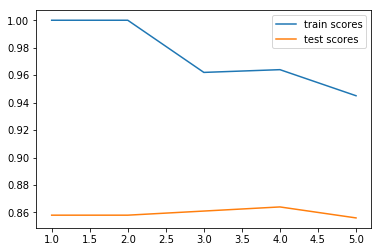

In [35]:
X, Y = get_data(2000)
Ntrain = 1000
Xtrain, Ytrain = X[:Ntrain], Y[:Ntrain]
Xtest, Ytest = X[Ntrain:], Y[Ntrain:]
train_scores = []
test_scores = []
ks = (1,2,3,4,5)
for k in ks:
    print("\nk =", k)
    knn = KNN(k)
    t0 = datetime.now()
    knn.fit(Xtrain, Ytrain)
    print("Training time:", (datetime.now() - t0))

    t0 = datetime.now()
    train_score = knn.score(Xtrain, Ytrain)
    train_scores.append(train_score)
    print("Train accuracy:", train_score)
    print("Time to compute train accuracy:", (datetime.now() - t0), "Train size:", len(Ytrain))

    t0 = datetime.now()
    test_score = knn.score(Xtest, Ytest)
    print("Test accuracy:", test_score)
    test_scores.append(test_score)
    print("Time to compute test accuracy:", (datetime.now() - t0), "Test size:", len(Ytest))

plt.plot(ks, train_scores, label='train scores')
plt.plot(ks, test_scores, label='test scores')
plt.legend()
plt.show()